In [5]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.dataset import Dataset

outcome_def = 'outcome'  # output
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# get data

In [6]:
df_train, df_tune, _ = Dataset().get_data()
df = df_train
processed_feats = df.keys().values.tolist()
print(processed_feats)

kwargs {'clean_data': {}, 'preprocess_data': {'frac_missing_allowed': 0.05}, 'extract_features': {'drop_negative_columns': False}}
['AlteredMentalStatus', 'LOC', 'ambulatory', 'FocalNeuroFindings', 'PainNeck', 'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head', 'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed', 'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar', 'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop', 'Clotheslining', 'AlteredMentalStatus2', 'FocalNeuroFindings2', 'PainNeck2', 'PosMidNeckTenderness2', 'TenderNeck2', 'Torticollis2', 'subinj_Head2', 'subinj_Face2', 'subinj_Ext2', 'subinj_TorsoTrunk2', 'outcome']


/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


**correlations between features**

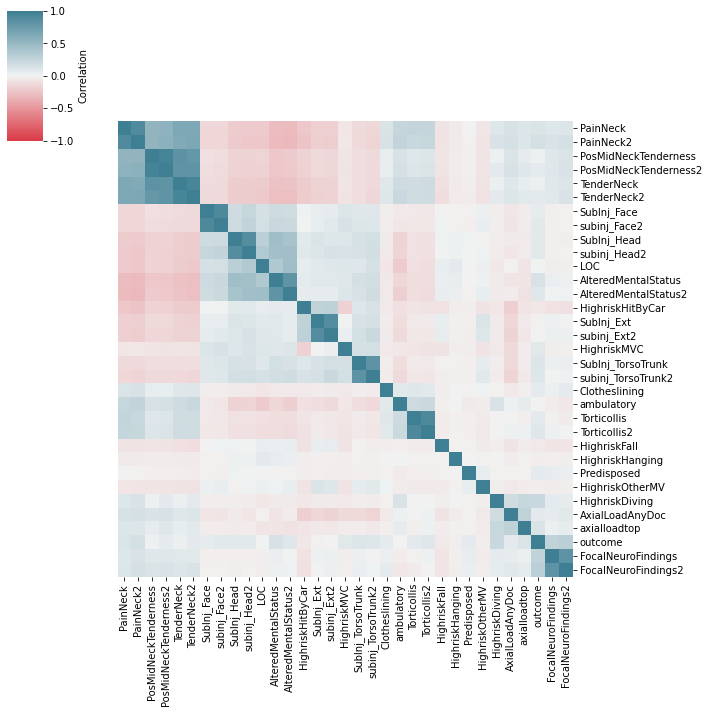

In [7]:
# corrs = df[feat_names + [outcome_def]].corr()
corrs = df[processed_feats].corr(method='pearson')
corrmap = sns.clustermap(corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
#                figsize=(12, 12))
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)

plt.show()
# plt.savefig('results/corrplot.png', dpi=300, bbox_inches='tight')

**individual correlations with outcome**

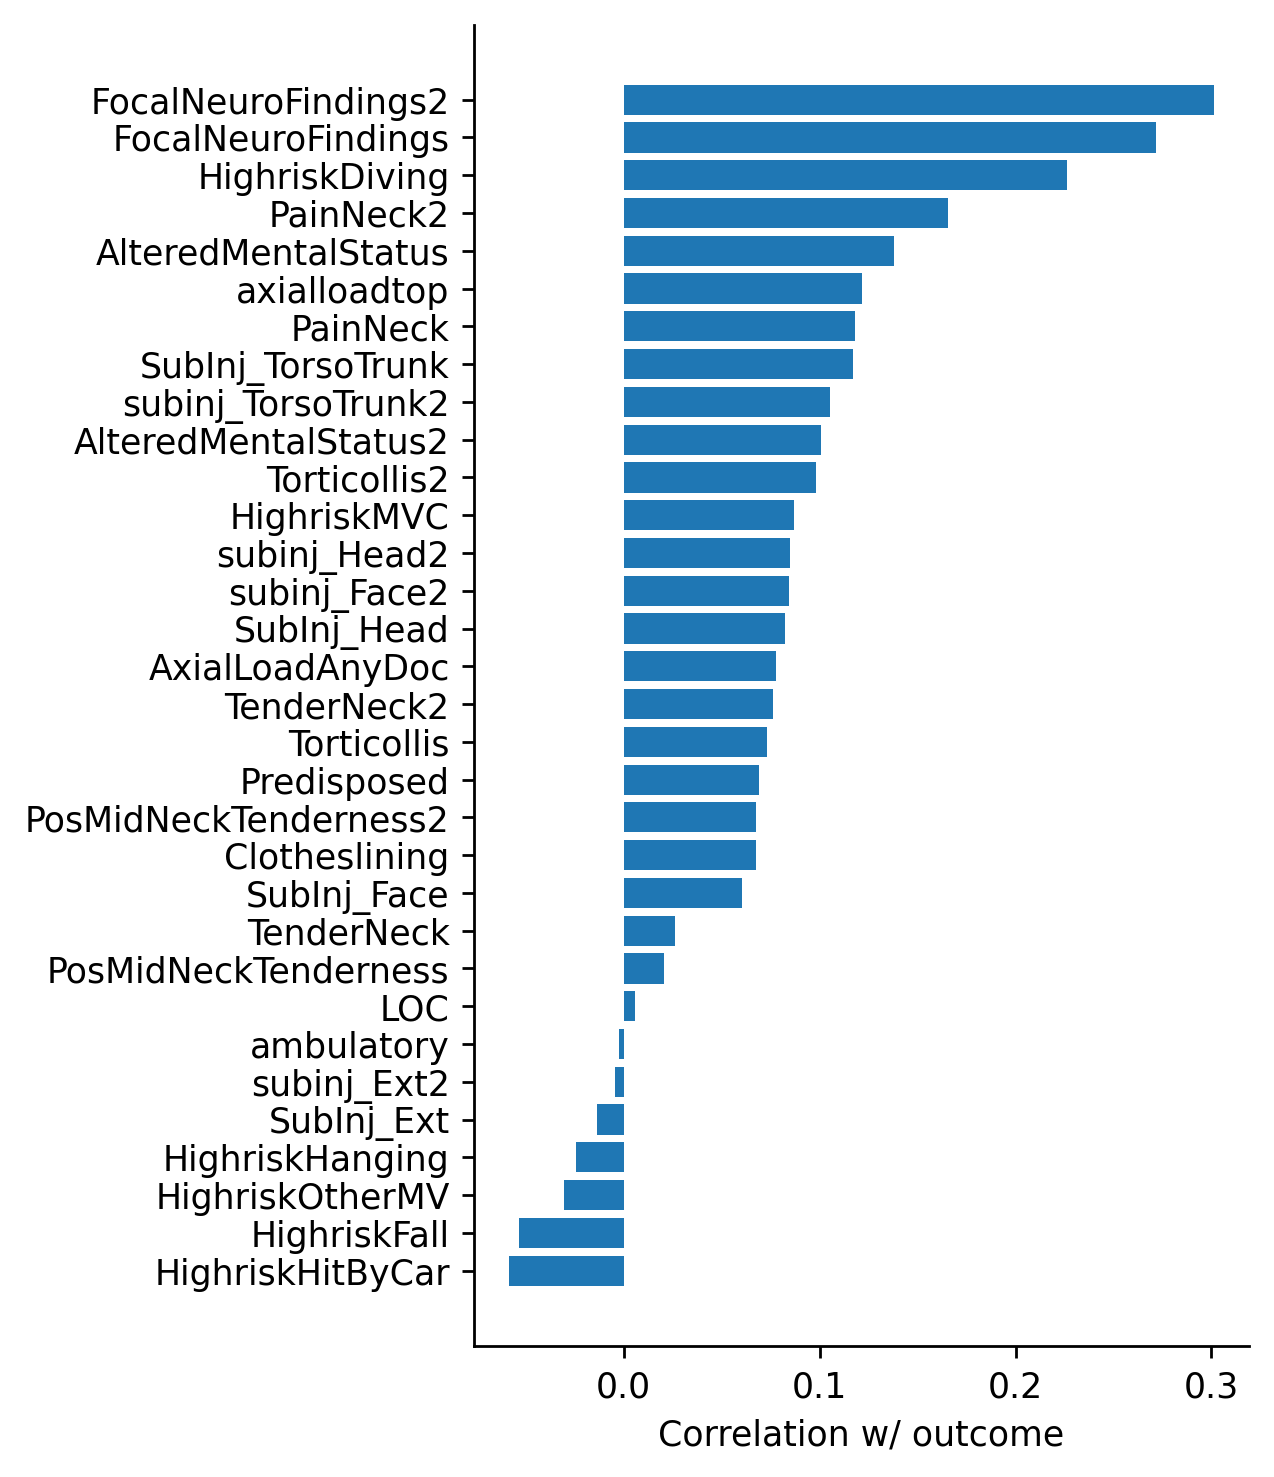

In [8]:
plt.figure(dpi=250, figsize=(4, 7))
vals = corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[:-1], vals[args][:-1])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

**subgroup risks (with sizes)**

In [9]:
def plot_subgroup_risks(df, head=None, tail=None):
    plt.figure(dpi=250, figsize=(4, 7))
    ks = np.array([k for k in df.keys()
                   if not k == outcome_def])
    mean_risk_baseline = df[outcome_def].mean() * 100
    if head is not None or tail is not None:
        ks = np.array([k for k in ks
                       if np.sum(df[k]) >= 10
                       and np.abs(np.mean(df[k]) - mean_risk_baseline) > 1
                       and not np.sum([df[k] == 1]) == 0])  # should have at least one IAI-I
    vals = np.array([np.mean(df[outcome_def][df[k] == 1]) for k in ks])
    vals[np.isnan(vals)] = mean_risk_baseline
    counts = np.array([np.sum([df[k] == 1]) for k in ks])
    args = np.argsort(vals)
    if head is not None:
        args = args[:head]
    if tail is not None:
        args = args[-tail:]
    labs = ks[args]
    vals = vals[args] * 100
    counts = counts[args]
    counts_norm = counts / np.nanmax(counts)
    ax = plt.subplot(111)
    plt.plot(vals, np.arange(vals.size), 'o', ms=1)
    plt.barh(y=np.arange(vals.size), width=vals, height=1.0 * counts_norm)
    plt.yticks(np.arange(vals.size), [lab.replace('_yes', '') for lab in labs])
    for i, (v, c) in enumerate(zip(vals, counts)):
        ax.text(v, i - 0.1, str(c), color=viz.cg, fontweight='bold')
    plt.axvline(mean_risk_baseline, color='gray', linestyle='--', alpha=0.5)
    ax.text(vals.max(), 1, 'Count in subgroup', color=viz.cg, fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel('IAI-I risk (%)')
    plt.show()


# plot_subgroup_risks(df[processed_feats + [outcome_def]])
# dd = df[(df['AbdTenderDegree_None']==1) & (df['GCSScore_Full_yes'] == 1)] # low-risk group left to split
# plot_subgroup_risks(dd[[k for k in processed_feats if not k in ['AbdTenderDegree_None', 'GCSScore_Full_yes']] + [outcome_def]])
dd = df[(df['AbdTenderDegree_None'] == 1) & (
            df['GCSScore_Full_yes'] == 1)]  # & (df['DecrBreathSound_yes'] == 0)] # low-risk group left to split
plot_subgroup_risks(dd[[k for k in processed_feats
                        if not k in ['AbdTenderDegree_None', 'GCSScore_Full_yes']]])

KeyError: 'AbdTenderDegree_None'

**joint correlations (or risks) with outcome joint**

/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


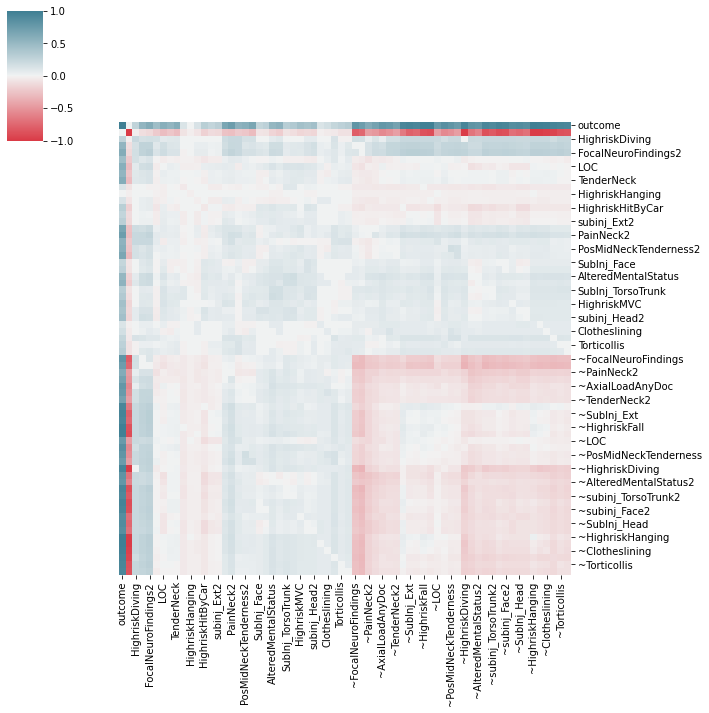

In [10]:
func = lambda x, y: np.corrcoef(x, y)[0, 1]  # corr
# func = lambda x, y: np.mean(y[x]) # frac high-risk
d = len(processed_feats)
mat = np.zeros((2 * d, 2 * d))
y = df[outcome_def]
for r in range(d):
    for c in range(d):
        xr = df[processed_feats[r]] == 1
        xc = df[processed_feats[c]] == 1
        mat[2 * r, 2 * c] = func(xr & xc, y)
        mat[2 * r + 1, 2 * c] = func(~xr & xc, y)
        mat[2 * r, 2 * c + 1] = func(xr & ~xc, y)
        mat[2 * r + 1, 2 * c + 1] = func(~xr & ~xc, y)

fs = np.array([[x, '~' + x] for x in processed_feats]).flatten()
mat[np.isnan(mat)] = 0
matt = pd.DataFrame(mat, index=fs, columns=fs)
vabs = np.max([np.abs(np.min(mat)), np.max(mat)])
vmin = -vabs
cmap = viz.cmap_div
if np.min(mat) >= 0:
    vmin = 0
    cmap = 'Blues'
corrmap = sns.clustermap(matt, cmap=cmap, vmin=vmin, vmax=vabs,
                         dendrogram_ratio=0.2, figsize=(10, 10), )
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)
#                row_cluster=False, col_cluster=False)
# plt.savefig('dendrogram.png', dpi=400)
# plt.tight_layout()
plt.show()

# features scatter plots

## continuous features

KeyError: 'GCSScore'

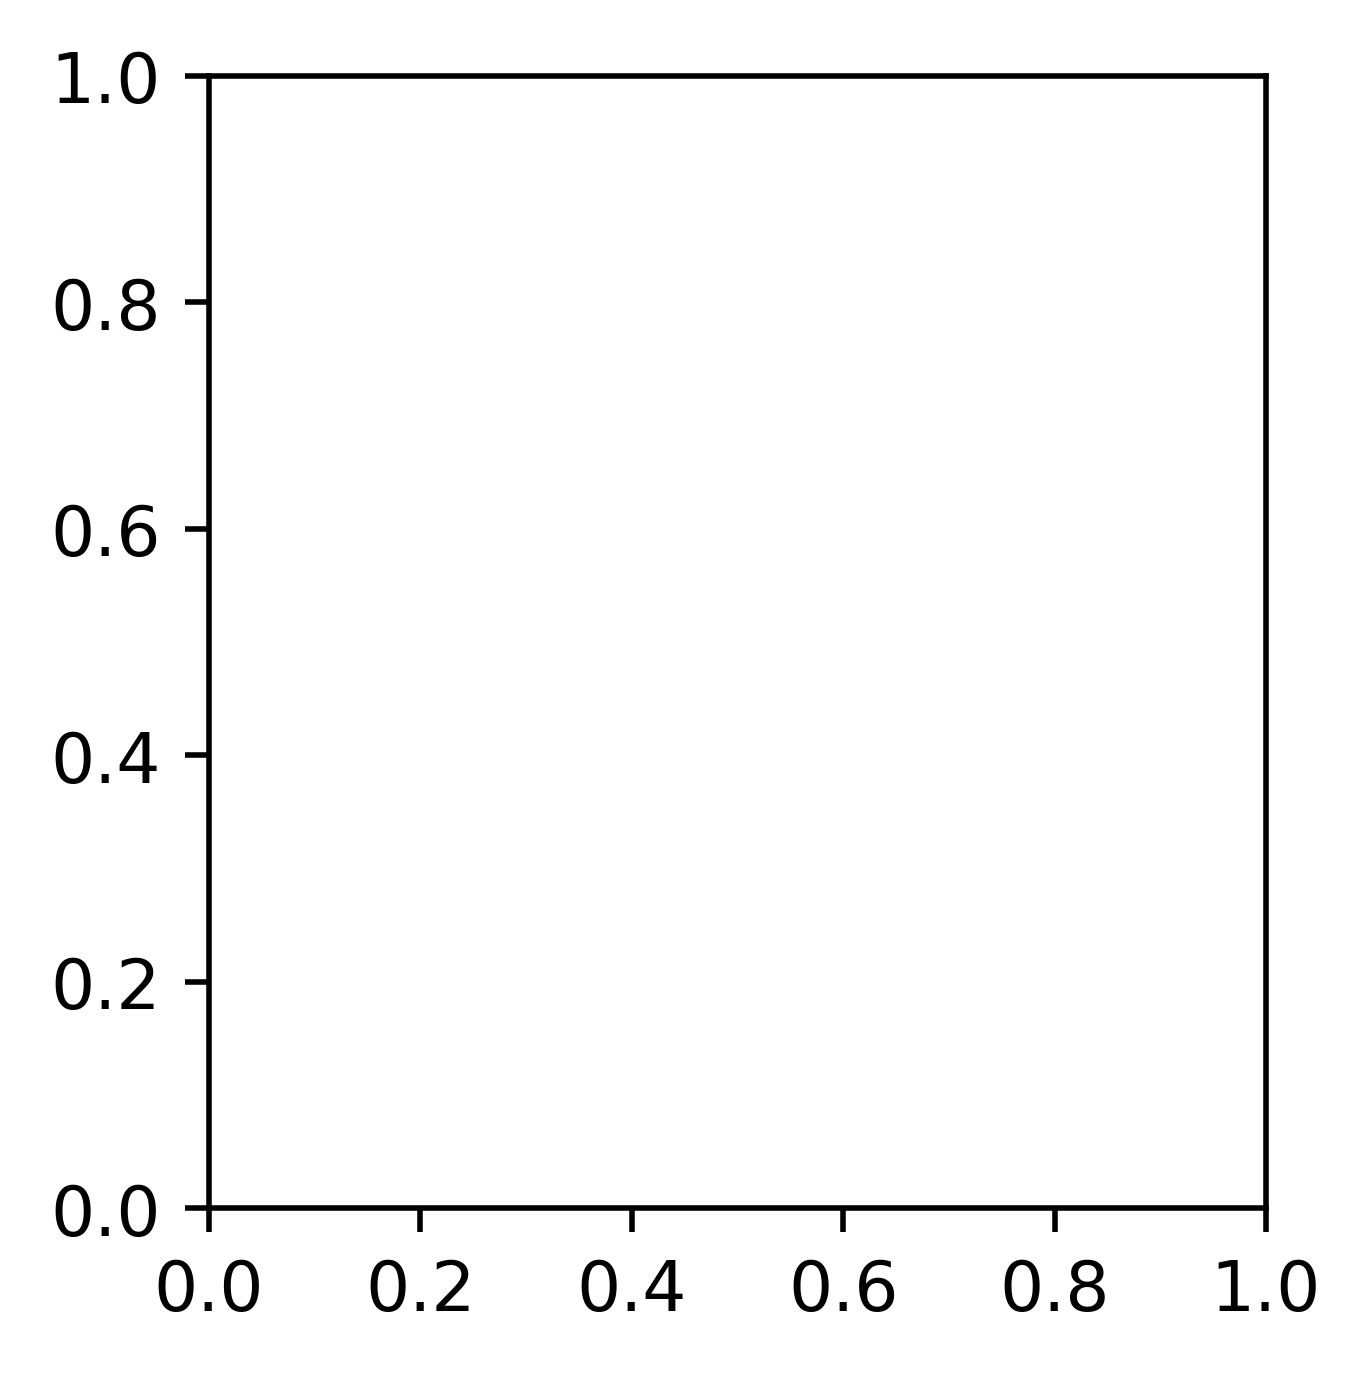

In [11]:
feats_numerical = ['GCSScore', 'Age']
# feats_categorical = ['AbdTenderDegree', 'Race', 'MOI']
R, C, = 1, 2
plt.figure(figsize=(6, 3), dpi=500)
for i in range(len(feats_numerical)):
    plt.subplot(R, C, i + 1)
    feat = feats_numerical[i]
    plt.hist(df[df[outcome_def] == 1][feat], density=True, alpha=1, label='pos', color=viz.cb)
    plt.hist(df[df[outcome_def] == 0][feat], density=True, alpha=0.5, label='neg', color=viz.cr)
    plt.xlabel(feat, fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

**we can cut GCSScore as whether it is 15 or not (14 is already pretty bad)**

In [57]:
feat = 'GCSScore'
print(np.unique(df[df[outcome_def] == 1][feat], return_counts=True))
print(np.unique(df[df[outcome_def] == 0][feat], return_counts=True))

(array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 12., 13., 14., 15.]), array([18,  1,  2,  3,  4,  3,  3,  4,  1,  4,  9, 63]))
(array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.]), array([ 119,   13,   16,   36,   31,   23,   35,   27,   37,   41,  145,
        372, 6216]))


## scatter plots

/Users/chandan/venvs/rule-vetting/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chandan/venvs/rule-vetting/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chandan/venvs/rule-vetting/lib/python3.7/site-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg

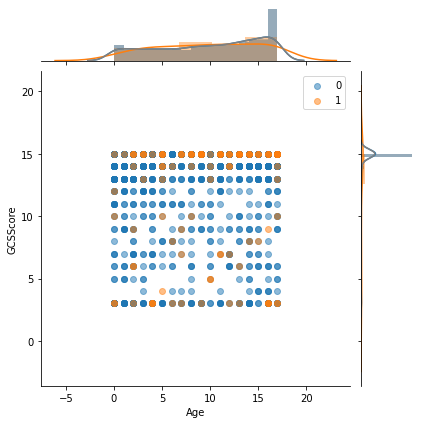

In [62]:
viz.jointplot_grouped('Age', 'GCSScore', 'outcome', df)

/Users/chandan/venvs/rule-vetting/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chandan/venvs/rule-vetting/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chandan/venvs/rule-vetting/lib/python3.7/site-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg

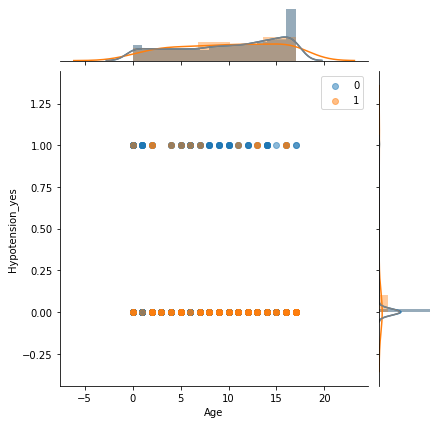

In [64]:
viz.jointplot_grouped('Age', 'Hypotension_yes', 'outcome', df)